In [6]:
import glob, os, sys
from pathlib import Path
import pyarrow.parquet as pq
import pyarrow as pa
import pandas as pd
import numpy as np
import datetime
import multiprocessing
import pathlib
import time
import matplotlib.pyplot as plt

In [67]:
seir = pq.read_table('model_output/east-coast_ImmediateCT_noSD/000000001.seir.parquet').to_pandas()

In [63]:
seir = pq.read_table('model_output/east-coast_ImmediateCT_noSD/000000001.seir.parquet')

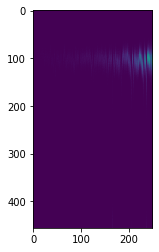

In [62]:
plt.imshow(

In [58]:
all_data['I_hosp'] = np.zeros_like(all_data['incidence'])

array([[4, 4, 4, ..., 0, 0, 0],
       [4, 4, 4, ..., 0, 0, 0],
       [4, 4, 4, ..., 0, 0, 0],
       ...,
       [4, 4, 4, ..., 0, 0, 0],
       [4, 4, 4, ..., 0, 0, 0],
       [4, 4, 4, ..., 0, 0, 0]], dtype=int32)

In [135]:
hosp =  pq.read_table('hospitalization/model_output/east-coast_DelayedCT/med_death_death-000000001.hosp.parquet').to_pandas()
hosp

OSError: Passed non-file path: hospitalization/model_output/east-coast_DelayedCT/med_death_death-000000001.hosp.parquet

In [176]:
hosp =  pq.read_table('hospitalization/model_output/east-coast_Uncontrolled/high_death_death-000000001.hosp.parquet').to_pandas()
hosp.dtypes

time         datetime64[ns]
geoid                object
incidI              float64
incidH              float64
hosp_curr           float64
incidICU            float64
icu_curr            float64
incidVent           float64
vent_curr           float64
incidD              float64
dtype: object

### Writing Board:

In [8]:
config_file = 'config_compare_outcome.yml'
scenarios = ['validation']
nsim=1
jobs=1
interactive=True
write_csv=False
write_parquet=True
index=1

from COVIDScenarioPipeline.SEIR.utils import config
import multiprocessing
import pathlib
import time


import click
config.set_file(config_file)


if not scenarios:
    scenarios = config["outcomes"]["scenarios"].as_str_seq()
print(f"Scenarios to be run: {', '.join(scenarios)}")

if not nsim:
    nsim = config["nsimulations"].as_number()

start = time.monotonic()
for scenario in scenarios:

    print(f"""
>> Scenario: {scenario}
>> Starting {nsim} model runs beginning from {index} on {jobs} processes
>> writing to folder : {2}
""")

Scenarios to be run: validation

>> Scenario: validation
>> Starting 1 model runs beginning from 1 on 1 processes
>> writing to folder : 2



In [10]:
import pandas as pd
import numpy as np

diffI = pd.read_parquet('model_output/seir/east-coast_Uncontrolled000000001.2020.06.27.14:54:04.UTC.seir.parquet')
diffI = diffI[diffI['comp'] == 'diffI']
dates = diffI.time
diffI.drop(['comp'], inplace = True, axis = 1)
places = diffI.drop(['time'], axis=1).columns
all_data = {}
# We store them as numpy matrices. Dimensions is dates X places
all_data['incidence'] = diffI.drop(['time'], axis=1).to_numpy().astype(np.int32)
shape = all_data['incidence'].shape

In [11]:
""" Quite fast shift implementation, along the first axis, 
    which is date. num is an integer not negative nor zero """
def shift(arr, num, fill_value=0):
    result = np.empty_like(arr)
    #if num > 0:
    result[:num] = fill_value
    result[num:] = arr[:-num]
    #elif num < 0:
    #    result[num:] = fill_value
    #    result[:num] = arr[-num:]
    #else:
    #    result[:] = arr
    return result

In [17]:
outcomes = pd.melt(diffI, id_vars='time', value_name = 'incidence', var_name='place')
config_outcomes = config["outcomes"]["settings"][scenario]
for new_comp in config_outcomes:
    
    if config_outcomes[new_comp]['source'].exists():
        # Read the config for this compartement
        source = config_outcomes[new_comp]['source'].as_str()
        probability = config_outcomes[new_comp]['probability']['value'].as_random_distribution()
        delay = config_outcomes[new_comp]['delay']['value'].as_random_distribution()

        # Create new compartement
        all_data[new_comp] = np.empty_like(all_data['incidence'])
        # Draw with from source compartement
        all_data[new_comp] = np.random.binomial(all_data[source], 
                                                probability(size = shape))

        # Shift to account for the delay
        all_data[new_comp] = shift(all_data[new_comp], int(delay(size=1)), fill_value=0)

        df = pd.DataFrame(all_data[new_comp], columns=places, index=dates)
        df.reset_index(inplace=True)
        df = pd.melt(df, id_vars='time', value_name = new_comp, var_name='place')
        outcomes = pd.merge(outcomes, df)


        # Make duration
        if config_outcomes[new_comp]['duration'].exists():
            duration = config_outcomes[new_comp]['duration']['value'].as_random_distribution()
            all_data[new_comp+'_curr'] = np.cumsum(all_data[new_comp], axis = 0) - shift(np.cumsum(all_data[new_comp], axis=0), int(duration(size=1)))

            df = pd.DataFrame(all_data[new_comp+'_curr'], columns=places, index=dates)
            df.reset_index(inplace=True)
            df = pd.melt(df, id_vars='time', value_name = new_comp+'_curr', var_name='place')
            outcomes = pd.merge(outcomes, df)
            
    elif config_outcomes[new_comp]['sum'].exists():
        outcomes[new_comp] = outcomes[config_outcomes[new_comp]['sum'].as_str_seq()].sum(axis=1)
    

In [13]:
all_data[new_comp+'_curr'

SyntaxError: unexpected EOF while parsing (<ipython-input-13-9ad390f58833>, line 1)

In [22]:
all_data['incidence']

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=int32)

(0, 100)

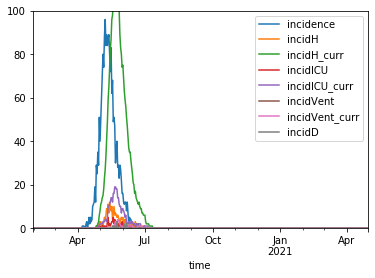

In [80]:
ax = outcomes[outcomes['place'] == '51091'].plot(x = 'time')
ax.set_ylim(0,100)

In [16]:

    parameters = {}
    for new_comp in config_outcomes:
        parameters[new_comp] = {}
        if config_outcomes[new_comp]['source'].exists():
            # Read the config for this compartement
            parameters[new_comp]['source'] = config_outcomes[new_comp]['source'].as_str()
            parameters[new_comp]['probability'] = np.mean(
                config_outcomes[new_comp]['probability']['value'].as_random_distribution()(size = 10000))
            
            parameters[new_comp]['delay'] = int(np.round(np.mean(
                config_outcomes[new_comp]['delay']['value'].as_random_distribution()(size = 10000))))
            
            if config_outcomes[new_comp]['duration'].exists():
                parameters[new_comp]['duration'] = int(np.round(np.mean(
                    config_outcomes[new_comp]['duration']['value'].as_random_distribution()(size = 10000))))
                if config_outcomes[new_comp]['duration']['name'].exists():
                    parameters[new_comp]['duration_name'] = config_outcomes[new_comp]['duration']['name'].as_str()
                else:
                    parameters[new_comp]['duration_name'] = new_comp+'_curr'
            
            if (config["outcomes"]["param_from_file"].get()):
                colname = 'R'+new_comp+'|'+parameters[new_comp]['source']
                if colname in branching_data.columns:
                    print(f"Using 'param_from_file' for probability {colname}")
                    parameters[new_comp]['probability'] = parameters[new_comp]['probability'] * \
                        branching_data[colname].to_numpy()
                else:
                    print(f"NOT using 'param_from_file' for probability {colname}")

        elif config_outcomes[new_comp]['sum'].exists():
            parameters[new_comp]['sum'] = config_outcomes[new_comp]['sum']
        else:
            raise ValueError(f"No 'source' or 'sum' specified for comp {new_comp}")

In [15]:
parameters

{}

In [209]:
%timeit np.mean(probability(10000000))

81.9 ms ± 1.36 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [217]:
parameters['hospitalization']['sum'].exist()

KeyError: 'sum'

In [18]:
    config_outcomes = config["outcomes"]["settings"][scenario]
    parameters = {}
    for new_comp in config_outcomes:
        parameters[new_comp] = {}
        if config_outcomes[new_comp]['source'].exists():
            # Read the config for this compartement
            parameters[new_comp]['source'] = config_outcomes[new_comp]['source'].as_str()
            parameters[new_comp]['probability'] = np.mean(
                config_outcomes[new_comp]['probability']['value'].as_random_distribution()(size = 10000))
            parameters[new_comp]['delay'] = np.mean(
                config_outcomes[new_comp]['delay']['value'].as_random_distribution()(size = 10000))
            
            if config_outcomes[new_comp]['duration'].exists():
                parameters[new_comp]['duration'] = np.mean(
                    config_outcomes[new_comp]['duration']['value'].as_random_distribution()(size = 10000))
            


        elif config_outcomes[new_comp]['sum'].exists():
            parameters[new_comp]['sum'] = config_outcomes[new_comp]['sum']

In [19]:
parameters

{}

In [184]:
out_df = pa.Table.from_pandas(outcomes, preserve_index = False)
pa.parquet.write_table(out_df, f"test.parquet")

In [3]:
import scipy.stats

In [82]:
parameters[new_comp]['delay']

19.599172807610472

In [ ]:
exp(X_pars[1] + X_pars[2]^2 / 2)

In [56]:
np.exp(1.23) + (0.79)**2 / 2)

1.4947442342529345

In [58]:
(0.79)**2 / 2

0.31205000000000005

In [57]:
np.exp(1.5)

4.4816890703380645

In [62]:
meanlog= 2.442
sdlog= 0.198

In [64]:
np.mean(scipy.stats.lognorm(s=sdlog, scale=np.exp(meanlog), loc=0).rvs(10**4))

11.684002751330507

In [94]:
branching_data = pd.read_csv('COVIDScenarioPipeline/Outcomes/data/usa-geoid-params-output.csv', converters={"geoid": str})

In [100]:
branching_data = branching_data[branching_data['geoid'].isin(diffI.drop('time', axis=1).columns)]

In [108]:
assert(branching_data.shape[0] ==diffI.drop('time', axis=1).columns.shape[0])

In [175]:
branching_data['RincidD|incidence'].to_numpy().astype(np.int).astype(np.double)

array([0., 0., 1., 0., 1., 0., 1., 0., 1., 1., 0., 0., 1., 0., 1., 0., 0.,
       1., 0., 0., 1., 0., 1., 1., 1., 1., 1., 0., 1., 1., 1., 0., 1., 0.,
       0., 0., 0., 1., 0., 0., 1., 1., 1., 0., 1., 0., 0., 0., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 0., 0., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 0., 1., 1., 1., 1., 1., 0., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 0., 1., 1., 1., 1., 1., 1., 1., 1., 1., 0., 1., 1., 1.,
       0., 1., 1., 0., 1., 1., 1., 1., 0., 0., 1., 1., 1., 0., 1., 1., 1.,
       1., 0., 0., 1., 0., 0., 1., 1., 1., 1., 1., 0., 0., 2., 1., 0., 1.,
       1., 1., 1., 1., 1., 0., 1., 0., 1., 1., 1., 1., 1., 1., 1., 0., 1.,
       0., 0., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 0., 0., 1., 1.,
       1., 0., 1., 1., 1., 1., 0., 0., 1., 1., 1., 0., 0., 1., 1., 1., 1.,
       1., 0., 1., 0., 1.

In [116]:
('R'+new_comp+'|'+parameters[new_comp]['source']) in branching_data.columns

False

In [117]:
'R'+new_comp+'|'+parameters[new_comp]['source']

'RincidD|incidH'

In [118]:
branching_data

,geoid,RincidD|incidence,RincidH|incidence,RincidVent|incidICU,RincidICU|incidH
316,10001,0.998860,0.991309,1.000001,0.994525
317,10003,0.961039,0.980814,1.000000,0.979636
318,10005,1.436205,1.274490,0.999987,1.236132
319,11001,0.913411,0.952960,0.999999,0.950545
1193,24001,1.298336,1.175052,0.999990,1.165125
...,...,...,...,...,...
2949,51800,0.897344,0.955297,1.000002,0.943254
2950,51810,0.841638,0.908939,1.000003,0.908255
2951,51820,1.224563,1.120141,0.999995,1.130607
2952,51830,0.974758,0.886794,1.000011,0.974589
